In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3
import matplotlib as mpl
pd.set_option('display.max_rows', 500)
%matplotlib inline

In [2]:
data_path = Path('../great_expectations_data/data')
output_path = Path('../great_expectations_data/cleaned_data')
figure_path = Path('../great_expectations_figures/')

# Venn diagram

In [3]:
vd = pd.read_csv(data_path/'venn_data.csv')

In [4]:
vd['label'] = vd.apply(lambda row: f'{row.author} ({row.year})', axis=1)

In [5]:
vd.groupby("meta_author").author.count()

meta_author
Keren    38
Ng       41
Zhang    22
Name: author, dtype: int64

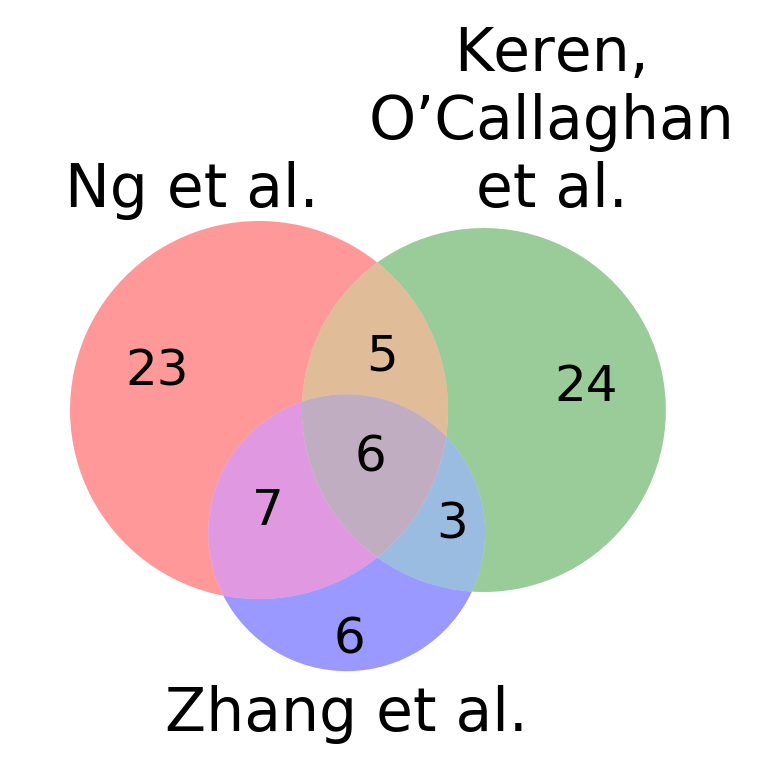

In [6]:
sns.set_context('paper', font_scale=1.5)
fig, ax = plt.subplots(1,  figsize=(3.54,3.54), dpi=250)
v = venn3((set(vd.loc[vd.meta_author=='Ng', 'label']),
       set(vd.loc[vd.meta_author=='Keren', 'label']),
       set(vd.loc[vd.meta_author=='Zhang', 'label'])),
     set_labels=['Ng et al.', 'Keren,\nO’Callaghan\net al.', 'Zhang et al.'],
     ax=ax)
cnc = v.get_circle_center(0)
ln =  v.get_label_by_id('A')
ln.set_x(cnc[0]-0.15)
ln.set_y(0.51)
ln.set_ha('center')

ckc = v.get_circle_center(1)
lk =  v.get_label_by_id('B')
lk.set_x(ckc[0]+0.15)
lk.set_y(0.51)
lk.set_ha('center')
fig.savefig(figure_path / 'meta_venn.png', dpi=300)

In [7]:
vd_sup = vd.groupby(['label'])[['meta_author']].agg(lambda x: (x == 'Zhang').sum()).rename(columns={"meta_author":"Zhang et al."})
vd_sup["Keren, O'Callagahan et al."] = vd.groupby(['label'])[['meta_author']].agg(lambda x: (x == 'Keren').sum())['meta_author']
vd_sup["Ng et al."] = vd.groupby(['label'])[['meta_author']].agg(lambda x: (x == 'Ng').sum())['meta_author']


In [8]:
vd_sup.to_csv(output_path/'venn_dataset_collapsed.csv')

# Task Trees

In [9]:
kd = pd.read_excel(data_path/'consistency_data.xlsx', sheet_name='keren_fmri_data')
nd = pd.read_excel(data_path/'consistency_data.xlsx', sheet_name='ng_data')

In [10]:
dd = pd.concat([kd,nd], sort=False, ignore_index=True)
dd['task_contrast'] = dd['task'] + ' ' + dd['ant_or_fb'] + ' ' + dd['contrast']
dd['full_contrast'] = dd['ant_or_fb'] + ' ' + dd['contrast']

In [11]:
task_counts = dd.groupby(['task']).label.nunique().reset_index().sort_values(['label', 'task'])

In [12]:
dd.groupby(['task','ant_or_fb', 'contrast']).count().shape

(64, 8)

In [13]:
multi_tasks = task_counts.loc[task_counts.label > 1, 'task'].values
uni_tasks = task_counts.loc[task_counts.label == 1, 'task'].values

In [14]:
dd.task.nunique()

18

In [15]:
dd.full_contrast.nunique()

35

In [16]:
mt_cd = dd.loc[dd.task.isin(multi_tasks), :].groupby(['task','ant_or_fb', 'contrast']).label.nunique().reset_index().sort_values(['label', 'task', 'contrast'], ascending=[False, True, True])

In [17]:
mt_cd.groupby('label').count()

,task,ant_or_fb,contrast
label,,,
1,39,39,39
2,6,6,6
3,1,1,1
4,2,2,2
5,4,4,4
10,1,1,1


In [18]:
len(multi_tasks)

11

In [19]:
task_counts

,task,label
0,AID,1
1,Autobiographical memory recall,1
3,Decision making,1
4,EEfRT,1
10,Memory,1
14,Self referential processing,1
16,Taste,1
6,Face matching,2
7,Gambling,2
8,Go/no go,2


In [20]:
ut_cd = dd.loc[~dd.task.isin(multi_tasks), :].groupby(['task','ant_or_fb', 'contrast']).label.nunique().reset_index().sort_values(['label', 'task', 'contrast'], ascending=[False, True, True])

In [21]:
ut_cd

,task,ant_or_fb,contrast,label
0,AID,Anticipation,reward > neutral,1
1,Autobiographical memory recall,Feedback,reward > neutral,1
2,Autobiographical memory recall,Feedback,very negative > negative,1
3,Autobiographical memory recall,Feedback,very positive > positive,1
4,Decision making,Feedback,positive > negative,1
5,EEfRT,Anticipation,high reward > low reward,1
6,Memory,Feedback,reward > neutral,1
7,Self referential processing,Feedback,negative > neutral,1
8,Self referential processing,Feedback,positive > neutral,1
9,Taste,Both,loss > neutral,1


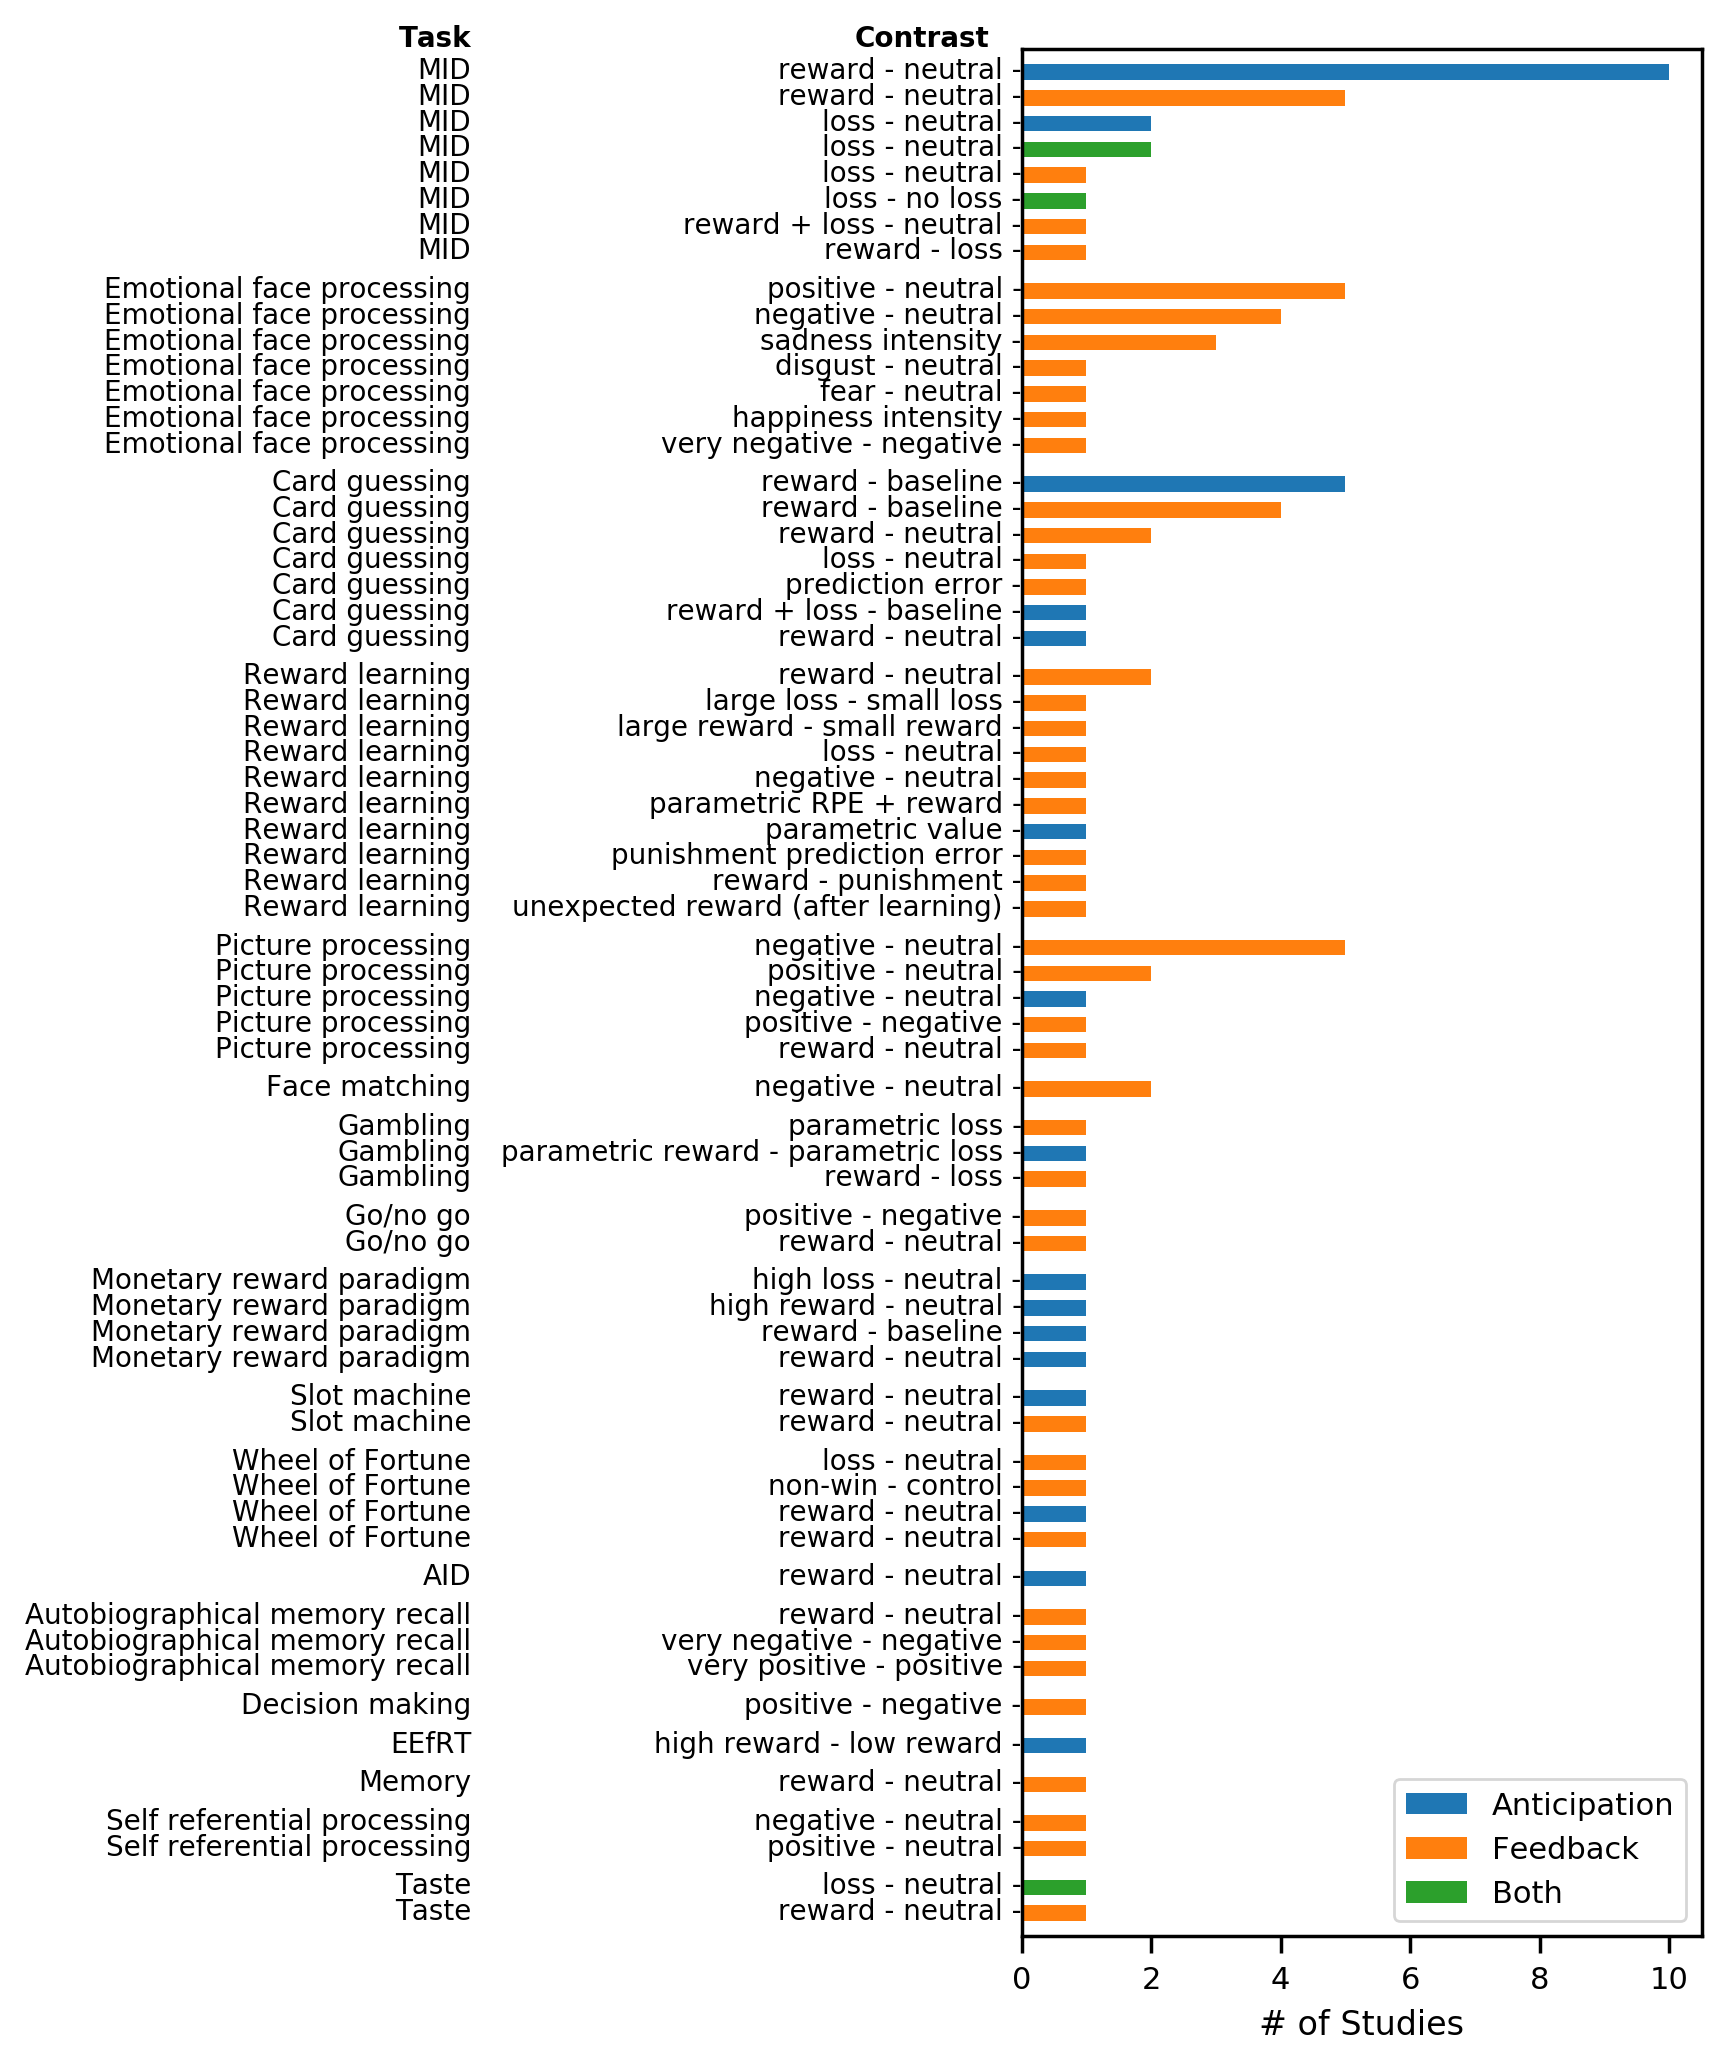

In [22]:

sns.set_context('paper', font_scale=1)
columns = {'task':-8.5, 'contrast':-0.5}
offset = 0.5
fig, ax = plt.subplots(1, figsize=(3.51, 10), dpi=250)
fs = 8
#df = mt_cd.loc[mt_cd.label > 1, :]
#df = mt_cd.copy()
df = pd.concat([mt_cd, ut_cd])
df = df.rename(columns={'label':'N'})
df['label'] = df.apply(lambda row: f'{row.task}: {row.ant_or_fb}, {row.contrast}', axis=1)
df = df.merge(task_counts.rename(columns={'label':'task_N'}), how='left', on='task')
df = df.sort_values(['task_N','task', 'N'], ascending=[False, True, False])

#df = df.append(pd.DataFrame([{'label': 'Tasks used in a single study', 'N': len(ut_cd)}]), sort=False)

df['contrast'] = df.contrast.str.replace (' > ', ' - ')
df = df.reset_index(drop=True).reset_index().rename(columns={'index':'y_pos', 'ant_or_fb':'phase'})
df['y_pos'] = len(df) - df.y_pos

task_offsets = df.groupby('task').first().sort_values('y_pos')
task_offsets['offset'] = np.arange(len(task_counts)) * offset
task_offsets = task_offsets.reset_index().loc[:, ['task', 'offset']]
df = df.merge(task_offsets, how='left', on='task')
df['y_pos'] = df.y_pos + df.offset


colors = {phase:cc for cc,phase in zip(sns.color_palette(n_colors = len(df.task.unique())),df.phase.unique())}
df['color'] = df.phase.apply(lambda tt: colors[tt])
ax.barh(df.y_pos, df.N.values, height=0.6, color=df.color.values)
ax.set_yticklabels('')
ax.set_yticks([])
ymin, ymax = ax.get_ylim()
for ix, row in df.iterrows():
        if pd.notnull(row.task):
            ax.text( columns['task'], row.y_pos - 0.25, row.task, ha='right', size=fs)
#         if pd.notnull(row.phase):
#             ax.text( columns['phase'], row.y_pos - 0.25, row.phase, ha='right', size=fs)
        if pd.notnull(row.contrast):
            ax.text( columns['contrast'] + 0.5, row.y_pos - 0.25, row.contrast + ' -', ha='right', size=fs)
#ax.text(0, df.y_pos.values[-1]-0.2, 'Contrasts from tasks used in a single study -', ha='right' )
for cc, cx in columns.items():
        ax.text(cx, df.y_pos.max() +1 , cc.title(), ha='right', weight='bold', size=fs)
ax.set_ylim((ymin+3, ymax-3))
ax.set_xlabel('# of Studies')


faces = []
legend_patches = []
y_pos = []
for cc in ax.get_children():
    if len(faces) == 3:
        break
    if cc.get_facecolor() not in faces:
        faces.append(cc.get_facecolor())
        legend_patches.append(cc)
        y_pos.append(cc.get_y())
        
legend_labels = pd.DataFrame(data=np.array(y_pos) + 0.3, columns=['y_pos']).merge(df.loc[:, ['y_pos', 'phase']]).phase.values
ax.legend(legend_patches, legend_labels)
fig.savefig(figure_path/'consistency.png', dpi=300, bbox_inches='tight')